In [18]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import wrf
import netCDF4 as nc
import warnings
import pyart
import tqdm
import metpy.calc as mpcalc
import glob
import pandas as pd

def calc_grad_theta(theta):
    
    theta_np = theta.values
    dx, dy = mpcalc.lat_lon_grid_deltas(theta.XLONG.values, theta.XLAT.values)
    dtheta_dy, dtheta_dx = mpcalc.gradient(theta_np, deltas=[dy.to("km"), dx.to("km")])
    grad_theta = dtheta_dy + dtheta_dx
    grad_theta = xr.DataArray(grad_theta.data,dims=["south_north","west_east"])
    grad_theta["XLONG"] = theta.XLONG
    
    return grad_theta

def load_era5(t):
    #Load ERA5
    era5_u = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/10u/2023/10u_era5_oper_sfc_20231001-20231031.nc")
    era5_v = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/10v/2023/10v_era5_oper_sfc_20231001-20231031.nc")

    step=2
    lon_slice = slice(140,165,step)
    lat_slice = slice(-30,-40,step)
    era5_u_slice = era5_u.sel(time=t,longitude=lon_slice,latitude=lat_slice)
    era5_v_slice = era5_v.sel(time=t,longitude=lon_slice,latitude=lat_slice)
    
    return era5_u_slice, era5_v_slice

def load_era5_pl(t,p=850):
    #Load ERA5
    era5_u = xr.open_dataset("/g/data/rt52/era5/pressure-levels/reanalysis/u/2023/u_era5_oper_pl_20231001-20231031.nc").sel(level=p,method="nearest")
    era5_v = xr.open_dataset("/g/data/rt52/era5/pressure-levels/reanalysis/v/2023/v_era5_oper_pl_20231001-20231031.nc").sel(level=p,method="nearest")

    step=2
    lon_slice = slice(150,157,step)
    lat_slice = slice(-35,-38,step)
    era5_u_slice = era5_u.sel(time=t,longitude=lon_slice,latitude=lat_slice)
    era5_v_slice = era5_v.sel(time=t,longitude=lon_slice,latitude=lat_slice)
    
    return era5_u_slice, era5_v_slice


warnings.simplefilter("ignore")

In [41]:
wrflist_d02 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d02*"))]
wrflist_d02_no_mp_heating = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_no_mp_heating/highres_d02*"))]
wrflist_d02_plus = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kplus/highres_d02*"))]
wrflist_d02_minus = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead_3Kminus/highres_d02*"))]
wrflist_d03 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d03*"))]
wrflist_d04 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-16_03:00:00"))]

100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


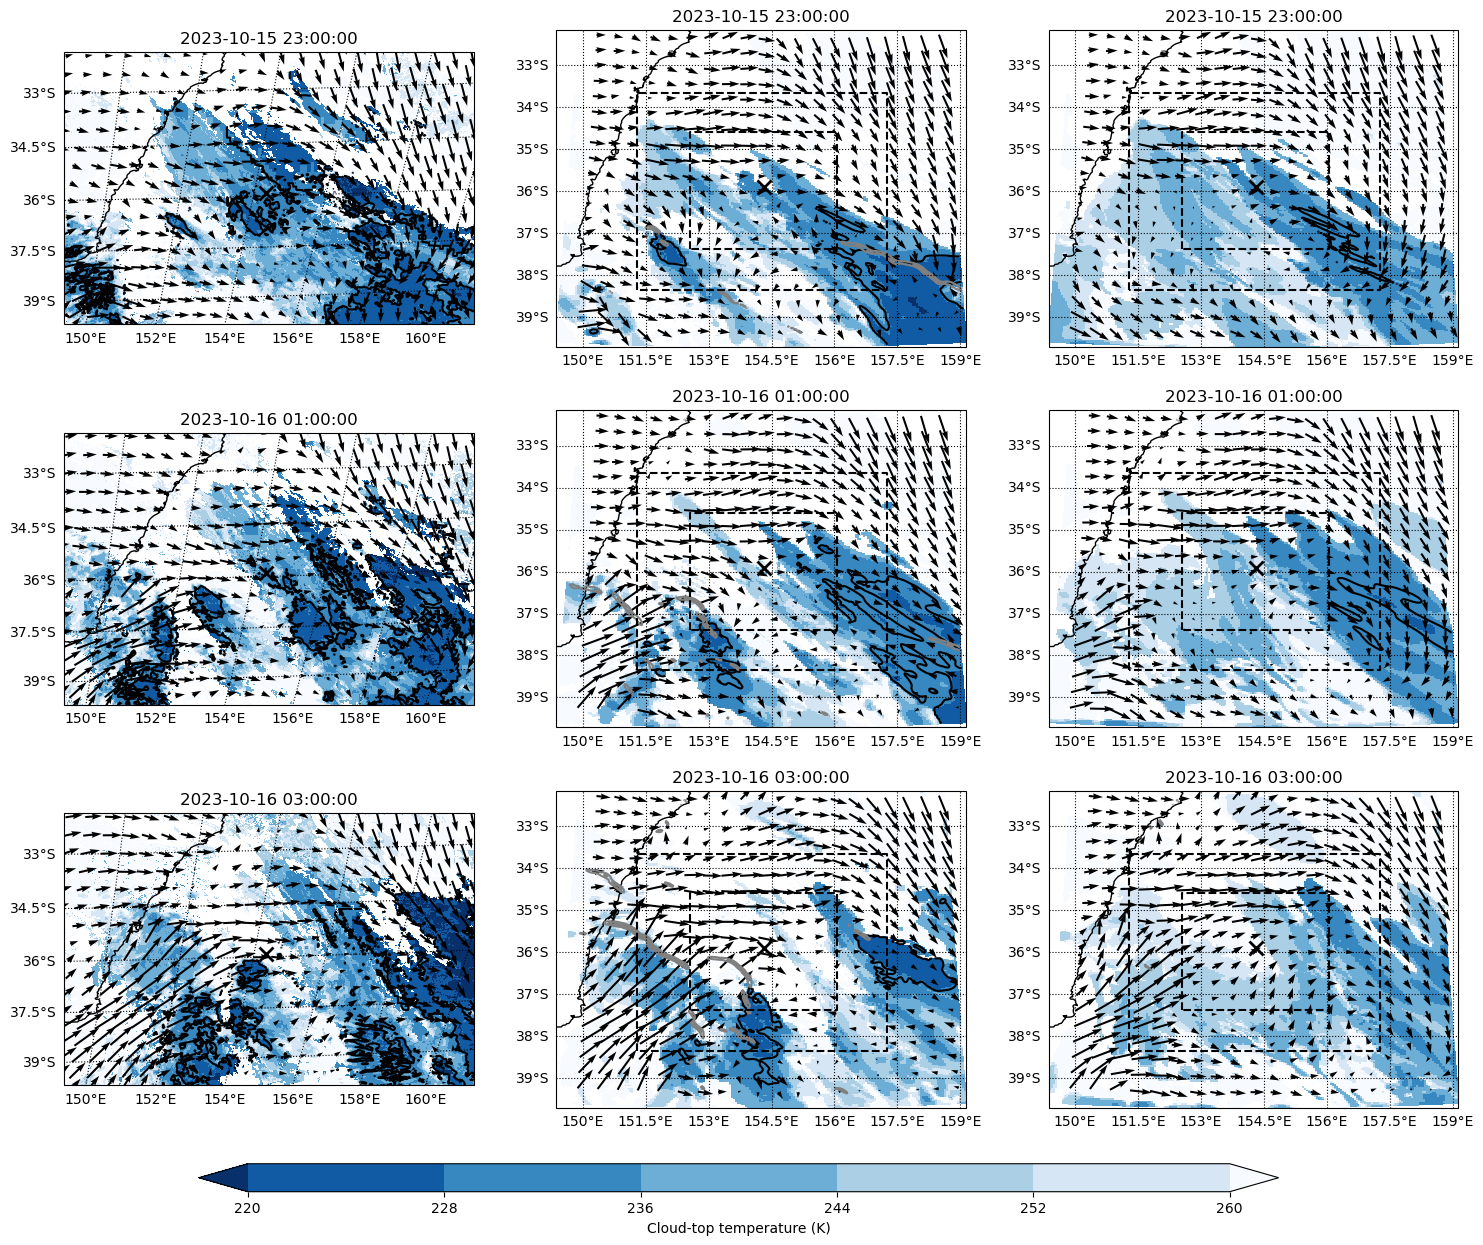

In [43]:
def load_hima(datetime):
    

    obs = xr.open_dataset("/g/data/rv74/satellite-products/arc/der/himawari-ahi/cloud/ctth/v2.0/2023/10/"+datetime.strftime("%d")+"/S_NWC_CTTH_HIMA09_HIMA-N-NR_"+datetime.strftime("%Y%m%dT%H%M%S")+"Z.nc")
    geos_proj = ccrs.Geostationary(central_longitude=obs.attrs["centre_projection_longitude"],satellite_height=35785863)
    ctth_tempe = obs.ctth_tempe.sel(nx=slice(0,3e6),ny=slice(-3e6,-5e6))
    
    return ctth_tempe, geos_proj


plt.figure(figsize = [18,14] )

times = [8,10,12]
cols = 3

cnt=0
for t in tqdm.tqdm(times):


    wrflist = wrflist_d02; step = 10    
    ax = plt.subplot(len(times), cols, (cnt*cols)+2,projection=ccrs.PlateCarree())
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    wrf_proj = wrf.get_cartopy(ctt)
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    ctt.plot(cmap="Blues_r",x="XLONG",y="XLAT",levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
    xr.plot.contour(ctt,ax=ax,colors=["k"],levels=[230],x="XLONG",y="XLAT")
    u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    
    theta = wrf.getvar(wrflist[t], "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[0.25,0.5,0.75,1],colors=["grey"],x="XLONG",y="XLAT",alpha=1)        
    plt.xlim([wrflist_d02[0]["XLONG"][:].min(),wrflist_d02[0]["XLONG"][:].max()])
    plt.ylim([wrflist_d02[0]["XLAT"][:].min(),wrflist_d02[0]["XLAT"][:].max()])
    d04_xlim = [wrflist_d04[0]["XLONG"][:].min(),wrflist_d04[0]["XLONG"][:].max()]
    d04_ylim = [wrflist_d04[0]["XLAT"][:].min(),wrflist_d04[0]["XLAT"][:].max()]
    d03_xlim = [wrflist_d03[0]["XLONG"][:].min(),wrflist_d03[0]["XLONG"][:].max()]
    d03_ylim = [wrflist_d03[0]["XLAT"][:].min(),wrflist_d03[0]["XLAT"][:].max()]    
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")
    plt.plot([d03_xlim[0],d03_xlim[0],d03_xlim[1],d03_xlim[1],d03_xlim[0]], [d03_ylim[0],d03_ylim[1],d03_ylim[1],d03_ylim[0],d03_ylim[0]], color="k", ls="--")
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)))
    ax.gridlines(draw_labels=["bottom","left"],ls=":",color="k")
    ax.coastlines()
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    extents = ax.get_extent()
    
    wrflist = wrflist_d02_no_mp_heating; step = 10    
    ax = plt.subplot(len(times), cols, (cnt*cols)+3,projection=ccrs.PlateCarree())
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    wrf_proj = wrf.get_cartopy(ctt)
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    ctt.plot(cmap="Blues_r",x="XLONG",y="XLAT",levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
    xr.plot.contour(ctt,ax=ax,colors=["k"],levels=[230],x="XLONG",y="XLAT")
    u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    
    theta = wrf.getvar(wrflist[t], "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[0.25,0.5,0.75,1],colors=["grey"],x="XLONG",y="XLAT",alpha=1)        
    plt.xlim([wrflist_d02[0]["XLONG"][:].min(),wrflist_d02[0]["XLONG"][:].max()])
    plt.ylim([wrflist_d02[0]["XLAT"][:].min(),wrflist_d02[0]["XLAT"][:].max()])
    d04_xlim = [wrflist_d04[0]["XLONG"][:].min(),wrflist_d04[0]["XLONG"][:].max()]
    d04_ylim = [wrflist_d04[0]["XLAT"][:].min(),wrflist_d04[0]["XLAT"][:].max()]
    d03_xlim = [wrflist_d03[0]["XLONG"][:].min(),wrflist_d03[0]["XLONG"][:].max()]
    d03_ylim = [wrflist_d03[0]["XLAT"][:].min(),wrflist_d03[0]["XLAT"][:].max()]    
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")
    plt.plot([d03_xlim[0],d03_xlim[0],d03_xlim[1],d03_xlim[1],d03_xlim[0]], [d03_ylim[0],d03_ylim[1],d03_ylim[1],d03_ylim[0],d03_ylim[0]], color="k", ls="--")
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)))
    ax.gridlines(draw_labels=["bottom","left"],ls=":",color="k")
    ax.coastlines()
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    extents = ax.get_extent()    
    
    datetime = pd.to_datetime(wrf.extract_times(wrflist,t))        
    ctth_tempe, geos_proj = load_hima(datetime)
    ax = plt.subplot(len(times), cols, (cnt*cols)+1,projection=geos_proj)
    wrf_proj = wrf.get_cartopy(ctt)
    c=ctth_tempe.plot(ax=ax,cmap=plt.get_cmap("Blues_r"),levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
    xr.plot.contour(ctth_tempe,ax=ax,colors=["k"],levels=[230])
    ax.gridlines(draw_labels=["bottom","left"],ls=":",color="k")
    ax.coastlines()    
    era5_u_slice, era5_v_slice = load_era5(datetime)
    x,y = np.meshgrid(era5_u_slice.longitude.values,era5_u_slice.latitude.values)
    x_t = geos_proj.transform_points(ccrs.Projection("WGS84"), x, y)[:,:,0]
    y_t = geos_proj.transform_points(ccrs.Projection("WGS84"), x, y)[:,:,1]
    u_t = geos_proj.transform_vectors(ccrs.Projection("WGS84"),x,y,era5_u_slice.u10.values,era5_v_slice.v10.values)[0]
    v_t = geos_proj.transform_vectors(ccrs.Projection("WGS84"),x,y,era5_u_slice.u10.values,era5_v_slice.v10.values)[1]
    ax.quiver(x_t,y_t,u_t,v_t,width=0.005,scale=200)
    ship_x,ship_y = geos_proj.transform_point(154.3239, -35.9070, ccrs.Projection("WGS84"))
    plt.plot(ship_x,ship_y, marker="x", color="k", ms=10, mew=2) 
    ax.set_extent(extents)    
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)))
    
    cnt=cnt+1
    
cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Cloud-top temperature (K)")

100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


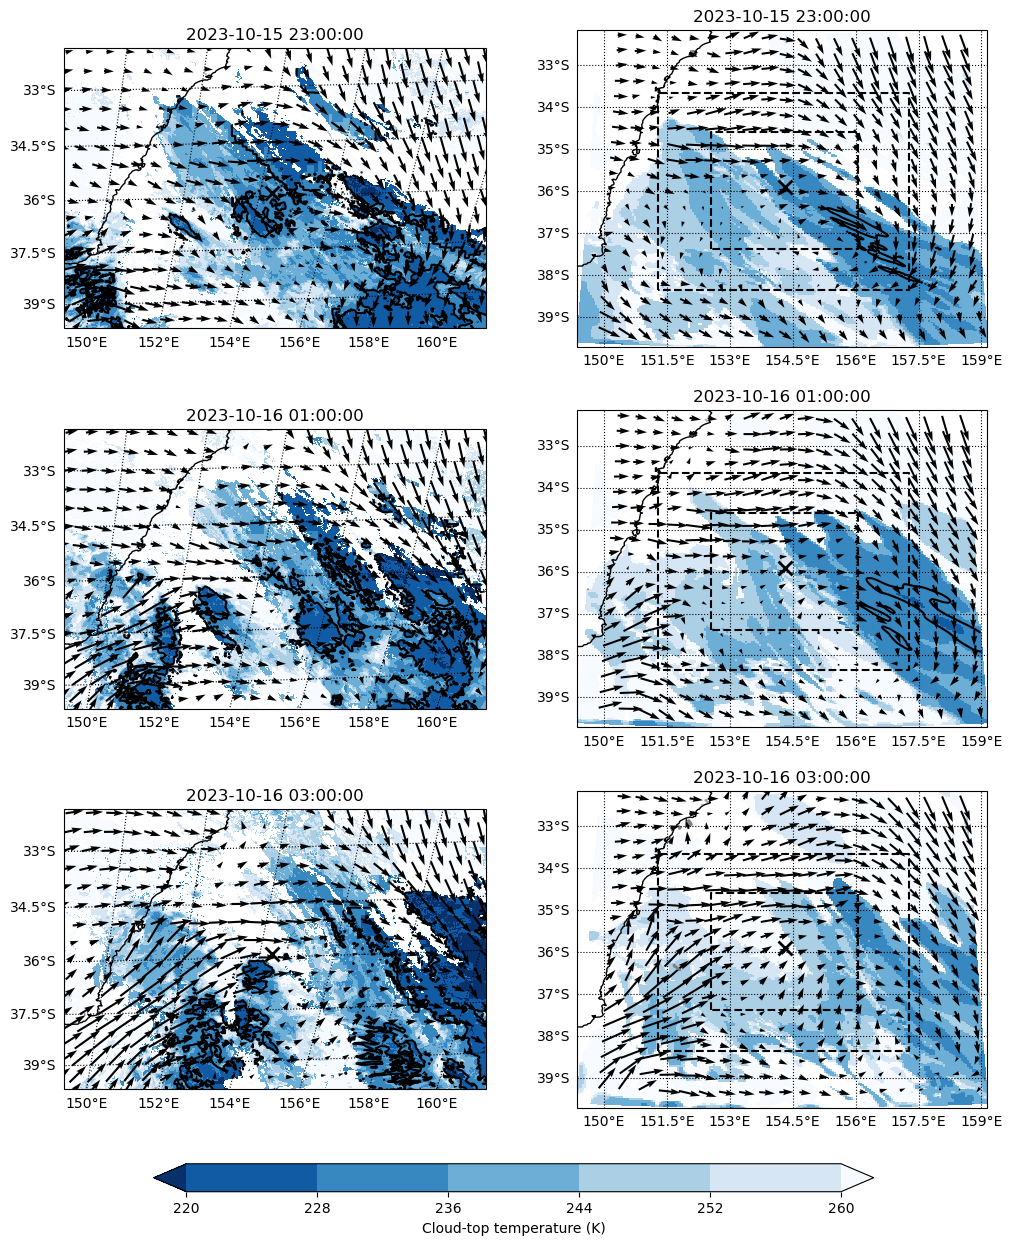

In [42]:
plt.figure(figsize = [12,14] )

times = [8,10,12]
cols = 2

cnt=0
for t in tqdm.tqdm(times):


    wrflist = wrflist_d02_no_mp_heating; step = 10    
    ax = plt.subplot(len(times), cols, (cnt*cols)+2,projection=ccrs.PlateCarree())
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    wrf_proj = wrf.get_cartopy(ctt)
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    ctt.plot(cmap="Blues_r",x="XLONG",y="XLAT",levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
    xr.plot.contour(ctt,ax=ax,colors=["k"],levels=[230],x="XLONG",y="XLAT")
    u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    
    theta = wrf.getvar(wrflist[t], "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[0.25,0.5,0.75,1],colors=["grey"],x="XLONG",y="XLAT",alpha=1)        
    plt.xlim([wrflist_d02[0]["XLONG"][:].min(),wrflist_d02[0]["XLONG"][:].max()])
    plt.ylim([wrflist_d02[0]["XLAT"][:].min(),wrflist_d02[0]["XLAT"][:].max()])
    d04_xlim = [wrflist_d04[0]["XLONG"][:].min(),wrflist_d04[0]["XLONG"][:].max()]
    d04_ylim = [wrflist_d04[0]["XLAT"][:].min(),wrflist_d04[0]["XLAT"][:].max()]
    d03_xlim = [wrflist_d03[0]["XLONG"][:].min(),wrflist_d03[0]["XLONG"][:].max()]
    d03_ylim = [wrflist_d03[0]["XLAT"][:].min(),wrflist_d03[0]["XLAT"][:].max()]    
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")
    plt.plot([d03_xlim[0],d03_xlim[0],d03_xlim[1],d03_xlim[1],d03_xlim[0]], [d03_ylim[0],d03_ylim[1],d03_ylim[1],d03_ylim[0],d03_ylim[0]], color="k", ls="--")
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)))
    ax.gridlines(draw_labels=["bottom","left"],ls=":",color="k")
    ax.coastlines()
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    extents = ax.get_extent()
    
    datetime = pd.to_datetime(wrf.extract_times(wrflist,t))        
    ctth_tempe, geos_proj = load_hima(datetime)
    ax = plt.subplot(len(times), cols, (cnt*cols)+1,projection=geos_proj)
    wrf_proj = wrf.get_cartopy(ctt)
    c=ctth_tempe.plot(ax=ax,cmap=plt.get_cmap("Blues_r"),levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
    xr.plot.contour(ctth_tempe,ax=ax,colors=["k"],levels=[230])
    ax.gridlines(draw_labels=["bottom","left"],ls=":",color="k")
    ax.coastlines()    
    era5_u_slice, era5_v_slice = load_era5(datetime)
    x,y = np.meshgrid(era5_u_slice.longitude.values,era5_u_slice.latitude.values)
    x_t = geos_proj.transform_points(ccrs.Projection("WGS84"), x, y)[:,:,0]
    y_t = geos_proj.transform_points(ccrs.Projection("WGS84"), x, y)[:,:,1]
    u_t = geos_proj.transform_vectors(ccrs.Projection("WGS84"),x,y,era5_u_slice.u10.values,era5_v_slice.v10.values)[0]
    v_t = geos_proj.transform_vectors(ccrs.Projection("WGS84"),x,y,era5_u_slice.u10.values,era5_v_slice.v10.values)[1]
    ax.quiver(x_t,y_t,u_t,v_t,width=0.005,scale=200)
    ship_x,ship_y = geos_proj.transform_point(154.3239, -35.9070, ccrs.Projection("WGS84"))
    plt.plot(ship_x,ship_y, marker="x", color="k", ms=10, mew=2) 
    ax.set_extent(extents)    
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)))
    
    cnt=cnt+1
    
cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Cloud-top temperature (K)")

100%|██████████| 5/5 [01:40<00:00, 20.05s/it]


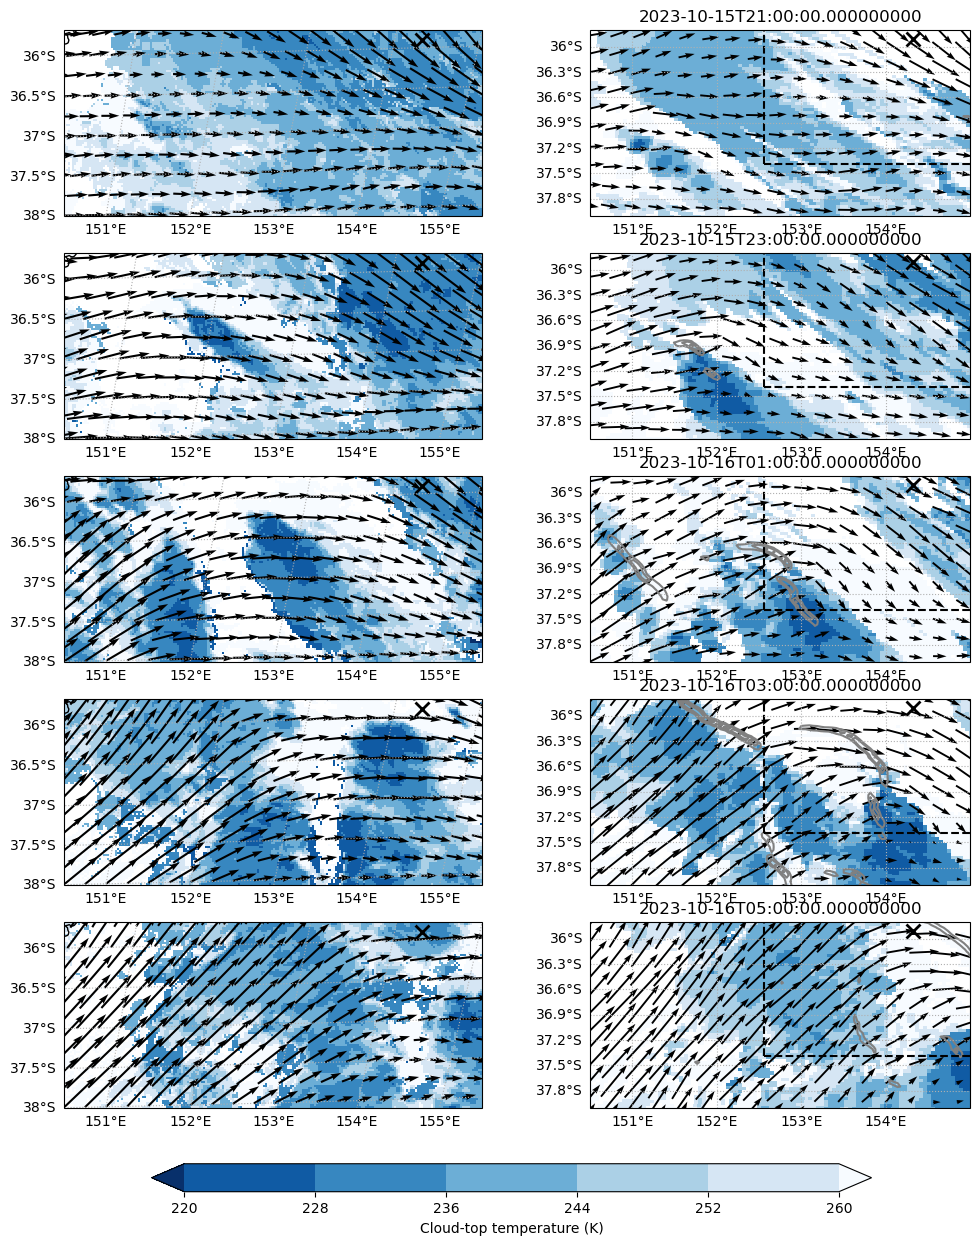

In [21]:
plt.figure(figsize = [12,14] )

times = [6,8,10,12,14]
cols = 2

cnt=0
for t in tqdm.tqdm(times):


    wrflist = wrflist_d02; step = 6    
    ax = plt.subplot(len(times), cols, (cnt*cols)+2,projection=ccrs.PlateCarree())
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    wrf_proj = wrf.get_cartopy(ctt)
    u = wrf.destagger(wrf.getvar(wrflist,"U",t),2,meta=True)
    v = wrf.destagger(wrf.getvar(wrflist,"V",t),1,meta=True)
    p = wrf.getvar(wrflist,"pressure",t)
    up = wrf.interplevel(u,p,850)
    vp = wrf.interplevel(v,p,850)    
    ctt.plot(cmap="Blues_r",x="XLONG",y="XLAT",levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
    u10 = up.rolling(south_north=step,west_east=step).mean().isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = vp.rolling(south_north=step,west_east=step).mean().isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    
    theta = wrf.getvar(wrflist[t], "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[0.25,0.5,0.75,1],colors=["grey"],x="XLONG",y="XLAT",alpha=1)        
    plt.xlim([150.5,155])
    plt.ylim([-38,-35.8])
    d04_xlim = [wrflist_d04[0]["XLONG"][:].min(),wrflist_d04[0]["XLONG"][:].max()]
    d04_ylim = [wrflist_d04[0]["XLAT"][:].min(),wrflist_d04[0]["XLAT"][:].max()]
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")
    plt.title(wrf.extract_times(wrflist,t))    
    ax.gridlines(draw_labels=["bottom","left"],ls=":")
    ax.coastlines()
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    extents = ax.get_extent()
    
    datetime = pd.to_datetime(wrf.extract_times(wrflist,t))        
    ctth_tempe, geos_proj = load_hima(datetime)
    ax = plt.subplot(len(times), cols, (cnt*cols)+1,projection=geos_proj)
    wrf_proj = wrf.get_cartopy(ctt)
    c=ctth_tempe.plot(ax=ax,cmap=plt.get_cmap("Blues_r"),levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
    ax.gridlines(draw_labels=["bottom","left"],ls=":")
    ax.coastlines()    
    era5_u_slice, era5_v_slice = load_era5_pl(datetime,850)
    x,y = np.meshgrid(era5_u_slice.longitude.values,era5_u_slice.latitude.values)
    x_t = geos_proj.transform_points(ccrs.Projection("WGS84"), x, y)[:,:,0]
    y_t = geos_proj.transform_points(ccrs.Projection("WGS84"), x, y)[:,:,1]
    u_t = geos_proj.transform_vectors(ccrs.Projection("WGS84"),x,y,era5_u_slice.u.values,era5_v_slice.v.values)[0]
    v_t = geos_proj.transform_vectors(ccrs.Projection("WGS84"),x,y,era5_u_slice.u.values,era5_v_slice.v.values)[1]
    ax.quiver(x_t,y_t,u_t,v_t,width=0.005,scale=200)
    ship_x,ship_y = geos_proj.transform_point(154.3239, -35.9070, ccrs.Projection("WGS84"))
    plt.plot(ship_x,ship_y, marker="x", color="k", ms=10, mew=2) 
    ax.set_extent(extents)  
    
    
    cnt=cnt+1
    
cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Cloud-top temperature (K)")

100%|██████████| 5/5 [03:28<00:00, 41.71s/it]


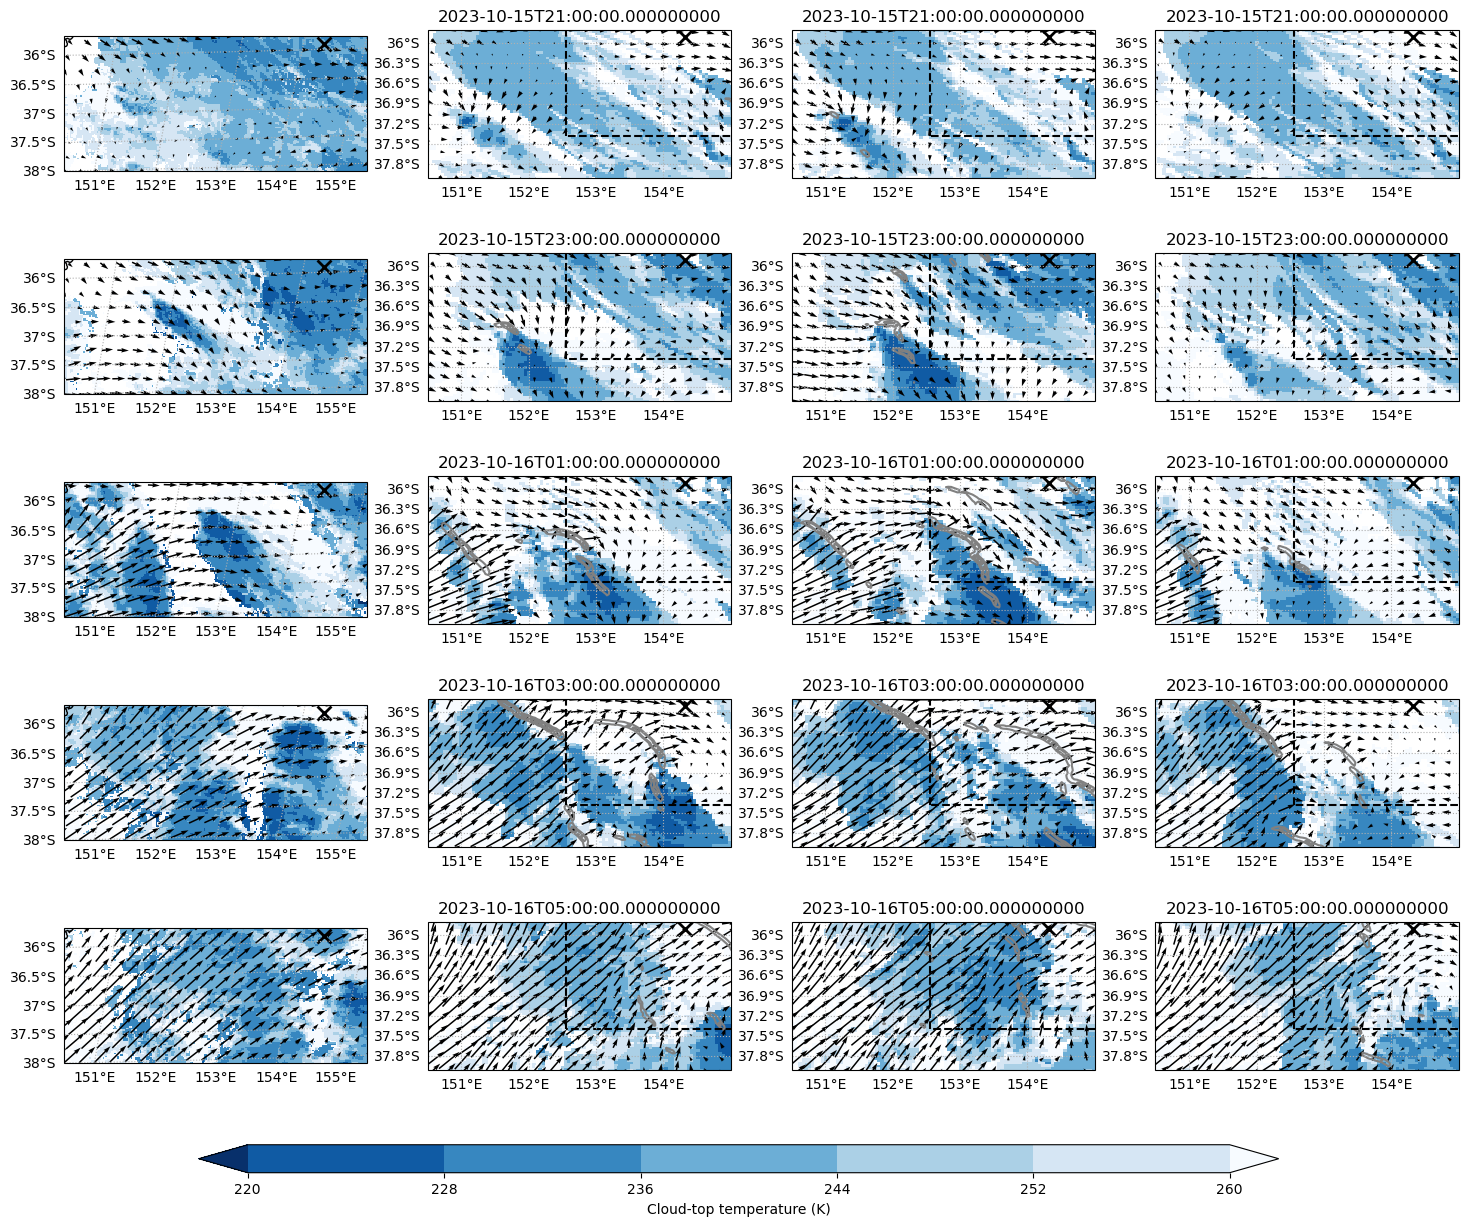

In [5]:
plt.figure(figsize = [18,14] )
wrf_proj = wrf.get_cartopy(ctt)

times = [6,8,10,12,14]
cols = 4

cnt=0
for t in tqdm.tqdm(times):


    wrflist = wrflist_d02; step = 5    
    ax = plt.subplot(len(times), cols, (cnt*cols)+2,projection=ccrs.PlateCarree())
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    ctt.plot(cmap="Blues_r",x="XLONG",y="XLAT",levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
    u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    
    theta = wrf.getvar(wrflist[t], "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[0.25,0.5,0.75,1],colors=["grey"],x="XLONG",y="XLAT",alpha=1)        
    plt.xlim([150.5,155])
    plt.ylim([-38,-35.8])
    d04_xlim = [wrflist_d04[0]["XLONG"][:].min(),wrflist_d04[0]["XLONG"][:].max()]
    d04_ylim = [wrflist_d04[0]["XLAT"][:].min(),wrflist_d04[0]["XLAT"][:].max()]
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")
    plt.title(wrf.extract_times(wrflist,t))    
    ax.gridlines(draw_labels=["bottom","left"],ls=":")
    ax.coastlines()
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    extents = ax.get_extent()
    
    wrflist = wrflist_d02_plus; step = 5    
    ax = plt.subplot(len(times), cols, (cnt*cols)+3,projection=ccrs.PlateCarree())
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    ctt.plot(cmap="Blues_r",x="XLONG",y="XLAT",levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
    u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    
    theta = wrf.getvar(wrflist[t], "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[0.25,0.5,0.75,1],colors=["grey"],x="XLONG",y="XLAT",alpha=1)        
    plt.xlim([150.5,155])
    plt.ylim([-38,-35.8])
    d04_xlim = [wrflist_d04[0]["XLONG"][:].min(),wrflist_d04[0]["XLONG"][:].max()]
    d04_ylim = [wrflist_d04[0]["XLAT"][:].min(),wrflist_d04[0]["XLAT"][:].max()]
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")
    plt.title(wrf.extract_times(wrflist,t))    
    ax.gridlines(draw_labels=["bottom","left"],ls=":")
    ax.coastlines()
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)    
    extents = ax.get_extent()    
    
    wrflist = wrflist_d02_minus; step = 5    
    ax = plt.subplot(len(times), cols, (cnt*cols)+4,projection=ccrs.PlateCarree())
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    ctt.plot(cmap="Blues_r",x="XLONG",y="XLAT",levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
    u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    
    theta = wrf.getvar(wrflist[t], "theta").isel(bottom_top=0)
    xr.plot.contour(calc_grad_theta(theta),levels=[0.25,0.5,0.75,1],colors=["grey"],x="XLONG",y="XLAT",alpha=1)        
    plt.xlim([150.5,155])
    plt.ylim([-38,-35.8])
    d04_xlim = [wrflist_d04[0]["XLONG"][:].min(),wrflist_d04[0]["XLONG"][:].max()]
    d04_ylim = [wrflist_d04[0]["XLAT"][:].min(),wrflist_d04[0]["XLAT"][:].max()]
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")
    plt.title(wrf.extract_times(wrflist,t))    
    ax.gridlines(draw_labels=["bottom","left"],ls=":")
    ax.coastlines()
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)    
    extents = ax.get_extent()        
    
    datetime = pd.to_datetime(wrf.extract_times(wrflist,t))        
    ctth_tempe, geos_proj = load_hima(datetime)
    ax = plt.subplot(len(times), cols, (cnt*cols)+1,projection=geos_proj)
    wrf_proj = wrf.get_cartopy(ctt)
    c=ctth_tempe.plot(ax=ax,cmap=plt.get_cmap("Blues_r"),levels=np.linspace(220,260,6),extend="both",add_colorbar=False)
    ax.gridlines(draw_labels=["bottom","left"],ls=":")
    ax.coastlines()    
    era5_u_slice, era5_v_slice = load_era5(datetime)
    x,y=np.meshgrid(era5_u_slice.longitude.values,era5_u_slice.latitude.values)
    x_t = geos_proj.transform_points(ccrs.Projection("WGS84"), x, y)[:,:,0]
    y_t = geos_proj.transform_points(ccrs.Projection("WGS84"), x, y)[:,:,1]
    u_t = geos_proj.transform_vectors(ccrs.Projection("WGS84"),x,y,era5_u_slice.u10.values,era5_v_slice.v10.values)[0]
    v_t = geos_proj.transform_vectors(ccrs.Projection("WGS84"),x,y,era5_u_slice.u10.values,era5_v_slice.v10.values)[1]
    ax.quiver(x_t,y_t,u_t,v_t,width=0.005,scale=200)
    ship_x,ship_y = geos_proj.transform_point(154.3239, -35.9070, ccrs.Projection("WGS84"))
    plt.plot(ship_x,ship_y, marker="x", color="k", ms=10, mew=2) 
    ax.set_extent(extents)    
    
    cnt=cnt+1
    
cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Cloud-top temperature (K)")

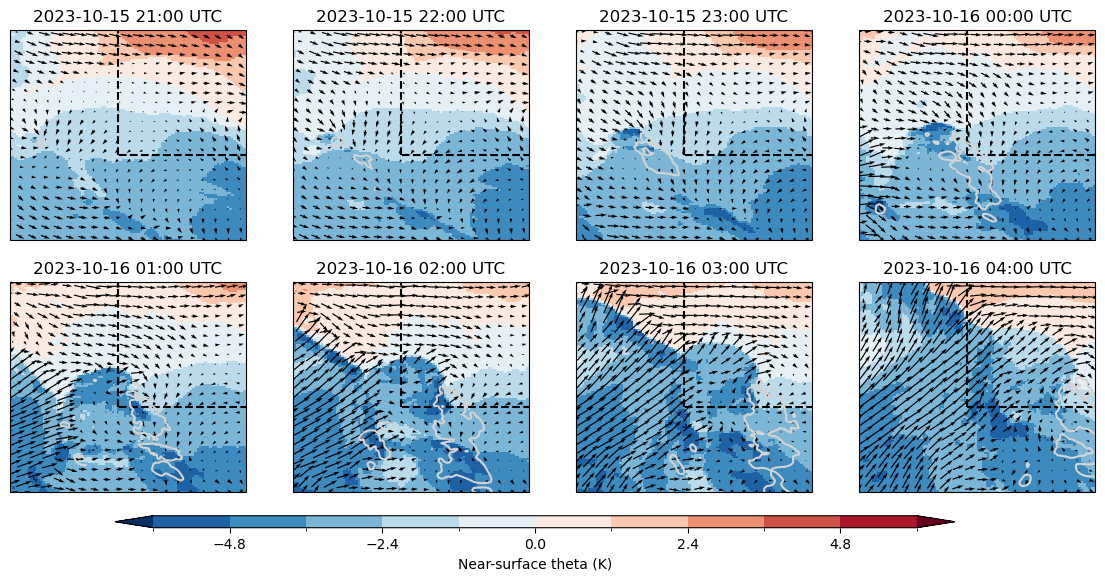

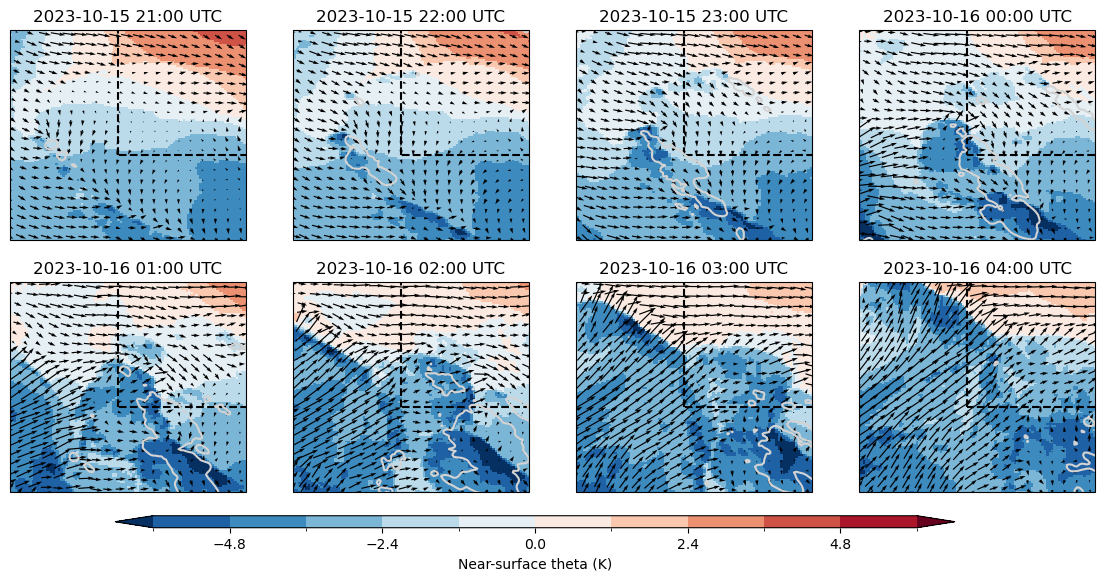

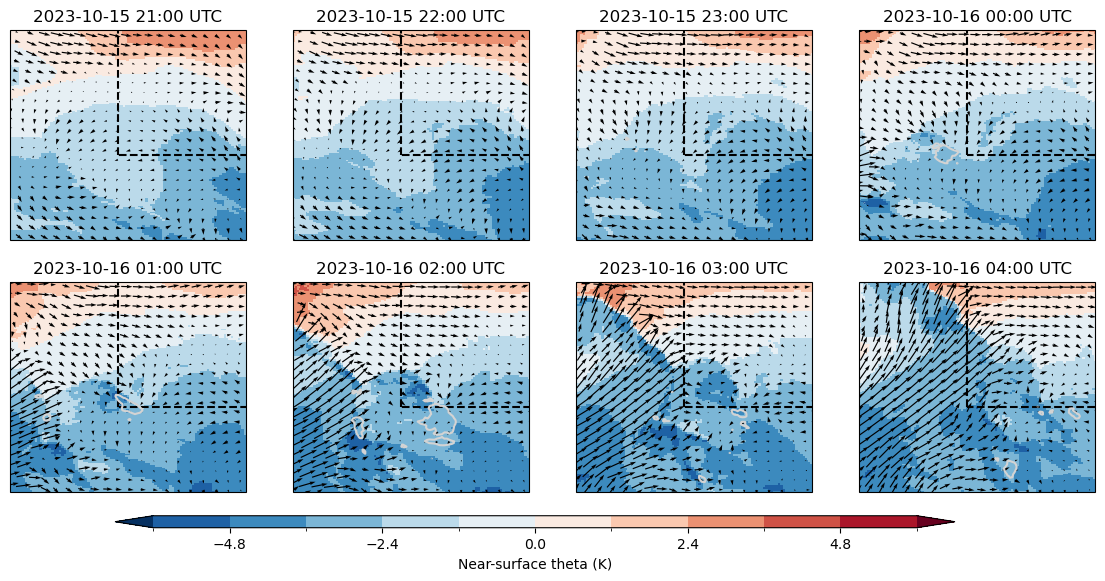

In [6]:
plt.figure(figsize=[14,6])
cnt=1
for t in [6,7,8,9,10,11,12,13]:
    wrflist = wrflist_d02
    theta = wrf.getvar(wrflist,"theta",t)
    ax=plt.subplot(2,4,cnt,projection=ccrs.PlateCarree())
    c=(theta.isel(bottom_top=0) - theta.isel(bottom_top=0).mean()).plot(levels=np.linspace(-6,6,11),cmap="RdBu_r",x="XLONG",y="XLAT",add_colorbar=False,extend="both")
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)        
    plt.xlim([150.5,155])
    plt.ylim([-39,-35])
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")    
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    xr.plot.contour(ctt,levels=[230],colors=["lightgrey"],x="XLONG",y="XLAT")
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)).strftime("%Y-%m-%d %H:%M UTC"))    
    cnt=cnt+1
    
cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Near-surface theta (K)")   

plt.figure(figsize=[14,6])
cnt=1
for t in [6,7,8,9,10,11,12,13]:
    wrflist = wrflist_d02_plus
    theta = wrf.getvar(wrflist,"theta",t)
    ax=plt.subplot(2,4,cnt,projection=ccrs.PlateCarree())
    c=(theta.isel(bottom_top=0) - theta.isel(bottom_top=0).mean()).plot(levels=np.linspace(-6,6,11),cmap="RdBu_r",x="XLONG",y="XLAT",add_colorbar=False,extend="both")
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)        
    plt.xlim([150.5,155])
    plt.ylim([-39,-35])
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")    
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    xr.plot.contour(ctt,levels=[230],colors=["lightgrey"],x="XLONG",y="XLAT")
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)).strftime("%Y-%m-%d %H:%M UTC"))    
    cnt=cnt+1
    
cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Near-surface theta (K)")   

plt.figure(figsize=[14,6])
cnt=1
for t in [6,7,8,9,10,11,12,13]:
    wrflist = wrflist_d02_minus
    theta = wrf.getvar(wrflist,"theta",t)
    ax=plt.subplot(2,4,cnt,projection=ccrs.PlateCarree())
    c=(theta.isel(bottom_top=0) - theta.isel(bottom_top=0).mean()).plot(levels=np.linspace(-6,6,11),cmap="RdBu_r",x="XLONG",y="XLAT",add_colorbar=False,extend="both")
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)        
    plt.xlim([150.5,155])
    plt.ylim([-39,-35])
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")    
    ctt = wrf.getvar(wrflist,"ctt",t,units="K",fill_nocloud=True)
    xr.plot.contour(ctt,levels=[230],colors=["lightgrey"],x="XLONG",y="XLAT")
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)).strftime("%Y-%m-%d %H:%M UTC"))    
    cnt=cnt+1
    
cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Near-surface theta (K)")   

100%|██████████| 3/3 [01:08<00:00, 22.73s/it]


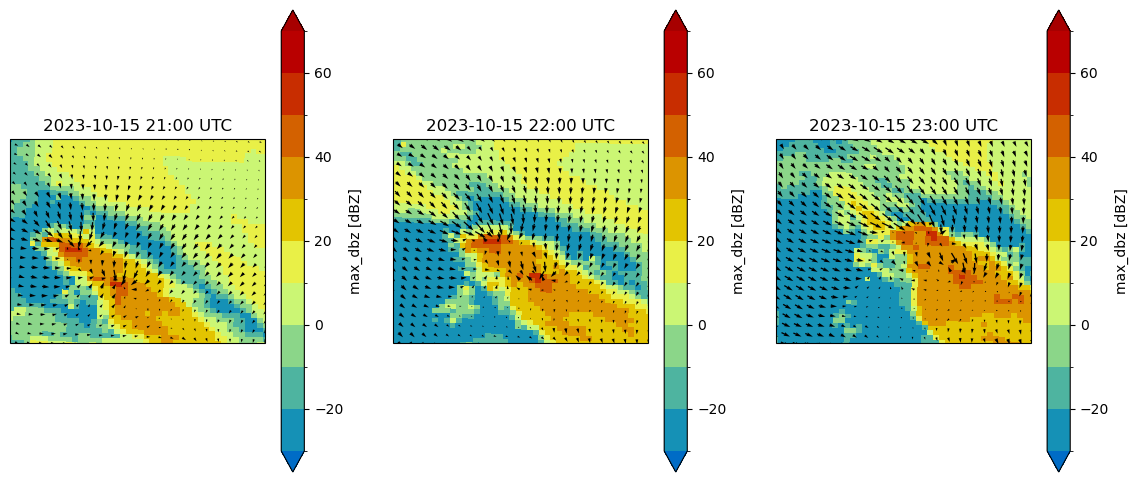

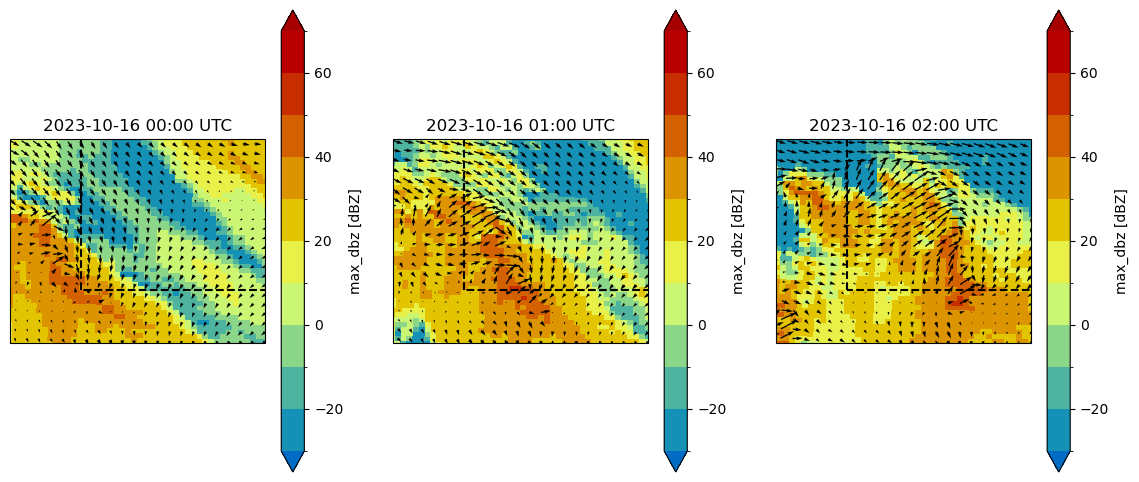

In [7]:
plt.figure(figsize=[14,6])
cnt=1
for t in tqdm.tqdm([6,7,8]):
    wrflist = wrflist_d02
    ax=plt.subplot(1,3,cnt,projection=ccrs.PlateCarree())
    #c=(wrf.getvar(wrflist,"W",t).min("bottom_top_stag")).plot(levels=np.linspace(-3,3,11),cmap="RdBu_r",x="XLONG",y="XLAT",add_colorbar=True,extend="both")
    c=(wrf.getvar(wrflist,"mdbz",t)).plot(levels=np.linspace(-30,70,11),cmap=pyart.graph.cm_colorblind.HomeyerRainbow,x="XLONG",y="XLAT",
                                          add_colorbar=True,extend="both")
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    step=2
    u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)        
    plt.xlim([150.5,152.5])
    plt.ylim([-37.8,-36.2])
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")    
    #xr.plot.contour(ctt,levels=[230],colors=["lightgrey"],x="XLONG",y="XLAT")
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)).strftime("%Y-%m-%d %H:%M UTC"))    
    cnt=cnt+1
    
plt.figure(figsize=[14,6])
cnt=1
for t in tqdm.tqdm([9,10,11]):
    wrflist = wrflist_d02
    ax=plt.subplot(1,3,cnt,projection=ccrs.PlateCarree())
    #c=(wrf.getvar(wrflist,"W",t).min("bottom_top_stag")).plot(levels=np.linspace(-3,3,11),cmap="RdBu_r",x="XLONG",y="XLAT",add_colorbar=True,extend="both")
    c=(wrf.getvar(wrflist,"mdbz",t)).plot(levels=np.linspace(-30,70,11),cmap=pyart.graph.cm_colorblind.HomeyerRainbow,x="XLONG",y="XLAT",
                                          add_colorbar=True,extend="both")
    uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
    step=2
    u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)        
    plt.xlim([152,154])
    plt.ylim([-37.8,-36.2])
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")    
    #xr.plot.contour(ctt,levels=[230],colors=["lightgrey"],x="XLONG",y="XLAT")
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)).strftime("%Y-%m-%d %H:%M UTC"))    
    cnt=cnt+1    

100%|██████████| 3/3 [00:53<00:00, 17.67s/it]


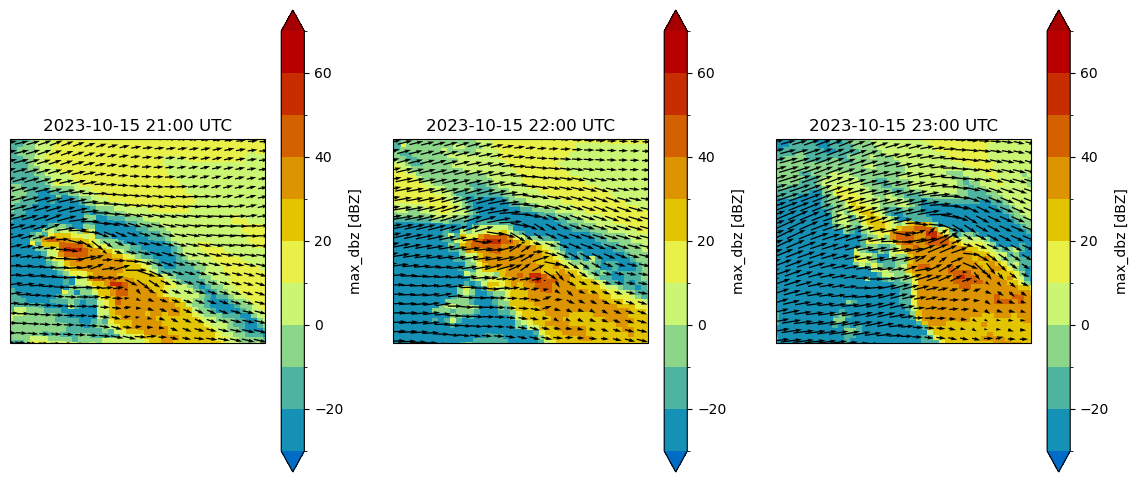

In [15]:
plt.figure(figsize=[14,6])
cnt=1
wrflist = wrflist_d02
for t in tqdm.tqdm([6,7,8]):

    ax=plt.subplot(1,3,cnt,projection=ccrs.PlateCarree())
    c=(wrf.getvar(wrflist,"mdbz",t)).plot(levels=np.linspace(-30,70,11),cmap=pyart.graph.cm_colorblind.HomeyerRainbow,x="XLONG",y="XLAT",
                                          add_colorbar=True,extend="both")
    u = wrf.destagger(wrf.getvar(wrflist,"U",t),2,meta=True)
    v = wrf.destagger(wrf.getvar(wrflist,"V",t),1,meta=True)
    p = wrf.getvar(wrflist,"pressure",t)
    up = wrf.interplevel(u,p,850)
    vp = wrf.interplevel(v,p,850)    
    step=2
    u10 = up.rolling(south_north=step,west_east=step).mean().isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = vp.rolling(south_north=step,west_east=step).mean().isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = p.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = p.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)        
    plt.xlim([150.5,152.5])
    plt.ylim([-37.8,-36.2])
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")    
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)).strftime("%Y-%m-%d %H:%M UTC"))    
    cnt=cnt+1

100%|██████████| 3/3 [00:42<00:00, 14.25s/it]


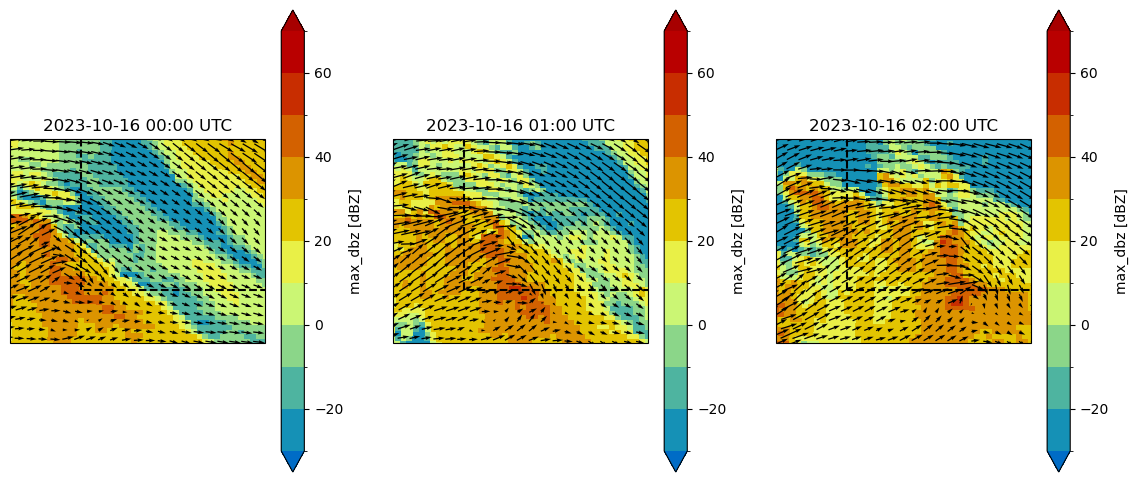

In [16]:
plt.figure(figsize=[14,6])
cnt=1
wrflist = wrflist_d02
for t in tqdm.tqdm([9,10,11]):

    ax=plt.subplot(1,3,cnt,projection=ccrs.PlateCarree())
    c=(wrf.getvar(wrflist,"mdbz",t)).plot(levels=np.linspace(-30,70,11),cmap=pyart.graph.cm_colorblind.HomeyerRainbow,x="XLONG",y="XLAT",
                                          add_colorbar=True,extend="both")
    u = wrf.destagger(wrf.getvar(wrflist,"U",t),2,meta=True)
    v = wrf.destagger(wrf.getvar(wrflist,"V",t),1,meta=True)
    p = wrf.getvar(wrflist,"pressure",t)
    up = wrf.interplevel(u,p,850)
    vp = wrf.interplevel(v,p,850)    
    step=2
    u10 = up.rolling(south_north=step,west_east=step).mean().isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    v10 = vp.rolling(south_north=step,west_east=step).mean().isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lat = p.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    lon = p.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
    plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)        
    plt.xlim([152,154])
    plt.ylim([-37.8,-36.2])
    plt.plot([d04_xlim[0],d04_xlim[0],d04_xlim[1],d04_xlim[1],d04_xlim[0]], [d04_ylim[0],d04_ylim[1],d04_ylim[1],d04_ylim[0],d04_ylim[0]], color="k", ls="--")    
    plt.title(pd.to_datetime(wrf.extract_times(wrflist,t)).strftime("%Y-%m-%d %H:%M UTC"))    
    cnt=cnt+1

(-37.8, -36.2)

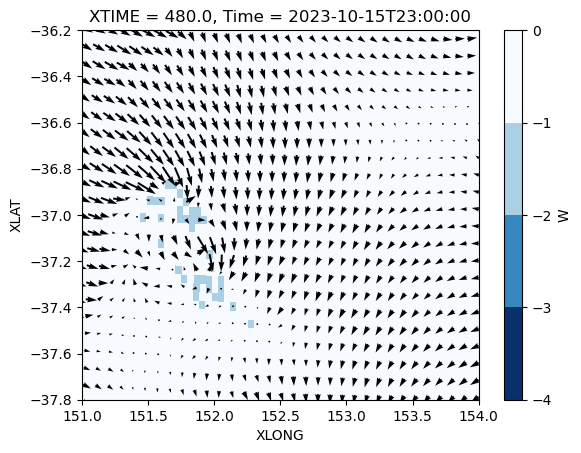

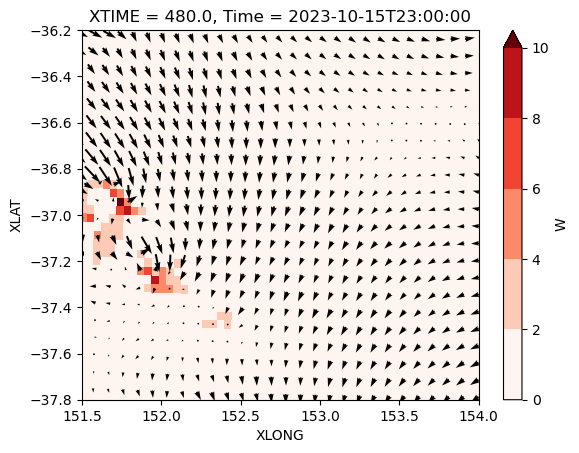

In [67]:
t=8
wrflist = wrflist_d02
step=2

#c=(wrf.getvar(wrflist,"mdbz",t)).plot(levels=np.linspace(-30,70,11),cmap=pyart.graph.cm_colorblind.HomeyerRainbow,x="XLONG",y="XLAT",
#                                      add_colorbar=True,extend="both")
(wrf.getvar(wrflist,"W",t)).min("bottom_top_stag").plot(x="XLONG",y="XLAT",cmap="Blues_r",levels=[-4,-3,-2,-1,0])
uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    
plt.xlim([151,154])
plt.ylim([-37.8,-36.2])

plt.figure()
(wrf.getvar(wrflist,"W",t)).max("bottom_top_stag").plot(x="XLONG",y="XLAT",cmap="Reds",levels=[0,2,4,6,8,10])
uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    
plt.xlim([151.5,154])
plt.ylim([-37.8,-36.2])

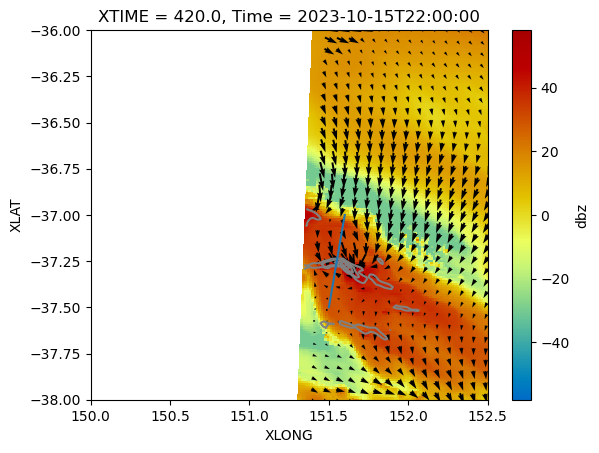

<Figure size 640x480 with 0 Axes>

In [431]:
t=7
wrflist = wrflist_d03

w = wrf.destagger(wrf.getvar(wrflist,"W",t),0,meta=True)
u = wrf.destagger(wrf.getvar(wrflist,"U",t),2,meta=True)
v = wrf.destagger(wrf.getvar(wrflist,"V",t),1,meta=True)
dbz = wrf.getvar(wrflist,"dbz",t)

vert = wrf.getvar(wrflist,"z",t)
theta = wrf.getvar(wrflist[t], "theta").isel(bottom_top=0)


start_lat, end_lat = [-37.5,-37]
start_lon, end_lon = [151.5,151.6]
start_point = wrf.CoordPair(lat=start_lat,lon=start_lon)
end_point = wrf.CoordPair(lat=end_lat,lon=end_lon)



step=5

dbz.max("bottom_top").plot(cmap=pyart.graph.cm_colorblind.HomeyerRainbow,x="XLONG",y="XLAT")
xr.plot.contour(calc_grad_theta(theta),levels=[0.1,0.25,0.5,0.75,1],colors=["grey"],x="XLONG",y="XLAT",alpha=1)        
plt.xlim([150,152.5])
plt.ylim([-38,-36])
plt.plot([start_lon,end_lon],[start_lat,end_lat])
uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
plt.quiver(lon,lat,u10,v10,scale=200,width=0.005)    

plt.figure()
wcross = wrf.vertcross(w,vert,wrfin=wrflist,start_point=start_point,end_point=end_point,timeidx=t,levels=np.linspace(0,10000,100))
ucross = wrf.vertcross(u,vert,wrfin=wrflist,start_point=start_point,end_point=end_point,timeidx=t,levels=np.linspace(0,10000,100))
vcross = wrf.vertcross(v,vert,wrfin=wrflist,start_point=start_point,end_point=end_point,timeidx=t,levels=np.linspace(0,10000,100))
dbzcross = wrf.vertcross(dbz,vert,wrfin=wrflist,start_point=start_point,end_point=end_point,timeidx=t,levels=np.linspace(0,10000,100))

(0.0, 8000.0)

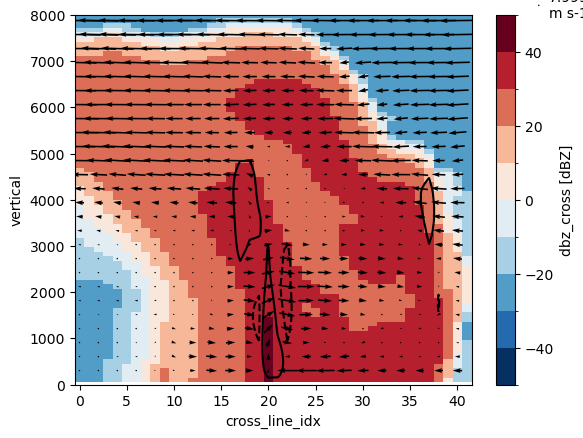

In [432]:
dbzcross.plot(levels=10)

uvw = xr.Dataset({"u":ucross,"v":vcross,"w":wcross}).assign_coords({"cross_line_idx":range(ucross.cross_line_idx.shape[0])})
uvw.isel(cross_line_idx=slice(0,-1,2),vertical=slice(0,-1,3)).plot.quiver("cross_line_idx","vertical","v","w",scale=200,width=0.004)
xr.plot.contour(uvw.w,levels=[-1,1],colors=["k"])
plt.ylim([0,8000])

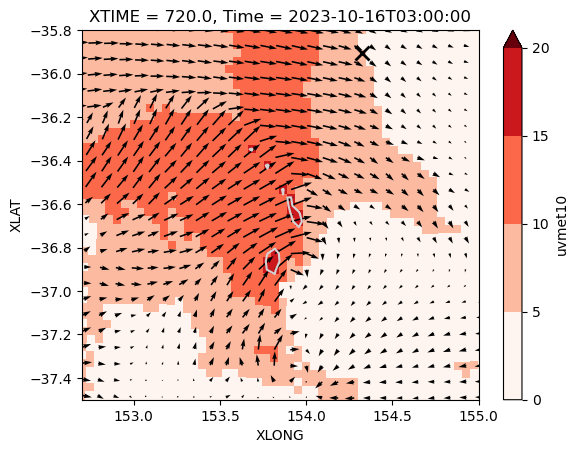

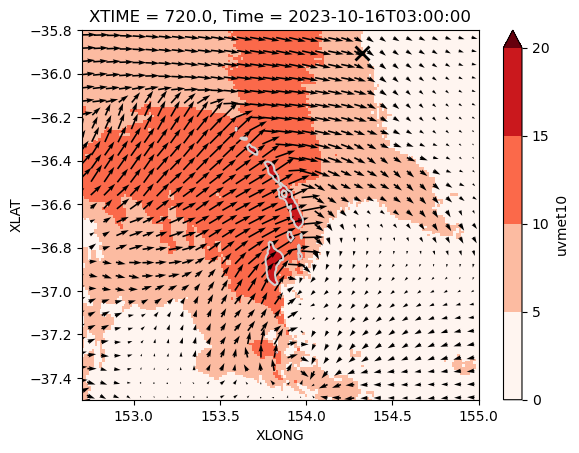

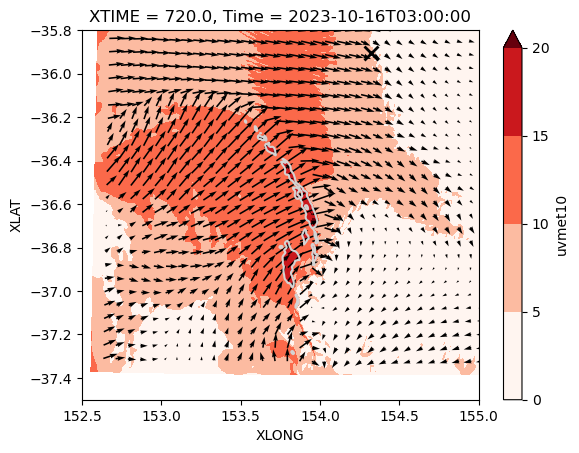

In [264]:
plt.figure()
t=12
wrflist = wrflist_d02
theta = wrf.getvar(wrflist,"theta",t).isel(bottom_top=0)
qrain = wrf.getvar(wrflist,"QRAIN",t).sum("bottom_top")
rain = wrf.getvar(wrflist,"RAINNC",t)
plt.xlim([152.7,155])
plt.ylim([-37.5,-35.8])
step=2
uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
np.sqrt(uvmet10.isel(u_v=0)**2+uvmet10.isel(u_v=1)**2).plot(cmap="Reds",x="XLONG",y="XLAT",levels=[0,5,10,15,20])
xr.plot.contour(np.sqrt(uvmet10.isel(u_v=0)**2+uvmet10.isel(u_v=1)**2),x="XLONG",y="XLAT",levels=[15],colors=["lightgrey"])
plt.quiver(lon,lat,u10,v10,scale=250,width=0.004)    
plt.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)    

plt.figure()
t=12
wrflist = wrflist_d03
theta = wrf.getvar(wrflist,"theta",t).isel(bottom_top=0)
qrain = wrf.getvar(wrflist,"QRAIN",t).sum("bottom_top")
rain = wrf.getvar(wrflist,"RAINNC",t)
plt.xlim([152.7,155])
plt.ylim([-37.5,-35.8])
step=5
uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
np.sqrt(uvmet10.isel(u_v=0)**2+uvmet10.isel(u_v=1)**2).plot(cmap="Reds",x="XLONG",y="XLAT",levels=[0,5,10,15,20])
xr.plot.contour(np.sqrt(uvmet10.isel(u_v=0)**2+uvmet10.isel(u_v=1)**2),x="XLONG",y="XLAT",levels=[15],colors=["lightgrey"])
plt.quiver(lon,lat,u10,v10,scale=250,width=0.004)    
plt.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)    

plt.figure()
t=0
wrflist = wrflist_d04
theta = wrf.getvar(wrflist,"theta",t).isel(bottom_top=0)
qrain = wrf.getvar(wrflist,"QRAIN",t).sum("bottom_top")
rain = wrf.getvar(wrflist,"RAINNC",t)
plt.xlim([152.5,155])
plt.ylim([-37.5,-35.8])
step=15
uvmet10 = wrf.getvar(wrflist,"uvmet10",t)
u10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=0,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
v10 = uvmet10.rolling(south_north=step,west_east=step).mean().isel(u_v=1,south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lat = uvmet10.XLAT.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
lon = uvmet10.XLONG.isel(south_north=slice(0,-1,step),west_east=slice(0,-1,step))
np.sqrt(uvmet10.isel(u_v=0)**2+uvmet10.isel(u_v=1)**2).plot(cmap="Reds",x="XLONG",y="XLAT",levels=[0,5,10,15,20])
xr.plot.contour(np.sqrt(uvmet10.isel(u_v=0)**2+uvmet10.isel(u_v=1)**2),x="XLONG",y="XLAT",levels=[15],colors=["lightgrey"])
plt.quiver(lon,lat,u10,v10,scale=250,width=0.004)    
plt.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)    